In [1]:
import pickle
import torch
import numpy as np
import MF
import math
from sklearn import cluster
from operator import itemgetter
from math import log
import torch.nn as nn
import torch.nn.functional as F
import time
import argparse
import pandas as pd
import utility
from scipy.sparse import csr_matrix, rand as sprand
from tqdm import tqdm
from MF import MF
import VAE
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


np.random.seed(0)
torch.manual_seed(0)

In [2]:
### Unpickling user and item matrices

test_like = np.load("./data/user_test_like.npy", allow_pickle=True)
train_like = np.load("./data/user_train_like.npy", allow_pickle=True)

### mtx_item[I]: the list of users that like item I
### mtx_user[U]: the list of items that user U like

with open("./data/item", "rb") as f: 
    mtx_item = pickle.load(f)

with open("./data/user", "rb") as f:
    mtx_user = pickle.load(f)
    
### Read the trained model
model = torch.load("./data/save.pt")
# Item matrix
Q = model.item_factors.weight.H.tolist()
# User matrix
P = model.user_factors.weight.H.tolist()

P = np.array(P)
Q = np.array(Q)

### Predicted matrix
Rec = np.matmul(P.T, Q)


### The test_like and train_like lists, but for item
### test_like_item[I]: the users who like item I in the test set
### train_like_item[I]: the users who like item I in the train set
test_like_item = []
for t in range(Rec.shape[1]):
    test_like_item.append([])
i = 0
for t in test_like:
    for tt in t:
        test_like_item[tt].append(i)
    i += 1

train_like_item = []
for t in range(Rec.shape[1]):
    train_like_item.append([])
i = 0
for t in train_like:
    for tt in t:
        train_like_item[tt].append(i)
    i += 1

    



In [3]:
###
Rec_train = []

for t in range(Rec.shape[0]):
    row = [0]*Rec.shape[1]
    for item in train_like[t]:
        row[item] = 1
    Rec_train.append(row)
Rec_train = np.array(Rec_train)


J_similar = Rec_train.dot(Rec_train.T)
J_similar = J_similar.astype("float32")

ones = np.ones((Rec_train.shape[0], Rec_train.shape[1]))
tmp = Rec_train + ones
sum_mtx = (tmp).dot(tmp.T) - J_similar - (ones.dot(ones.T))
tmp = sum_mtx - J_similar
J_similar = J_similar/tmp

### Diagonal elements are manually set to 0
for t in range(J_similar.shape[0]):
    J_similar[t][t] = 0



Rec_train_item = Rec_train.T
J_similar_item = Rec_train_item.dot(Rec_train_item.T)
J_similar_item = J_similar_item.astype("float32")

ones = np.ones((Rec_train_item.shape[0], Rec_train_item.shape[1]))
tmp = Rec_train_item + ones
sum_mtx = (tmp).dot(tmp.T) - J_similar_item - (ones.dot(ones.T))
tmp = sum_mtx - J_similar_item
J_similar_item = J_similar_item/tmp
            
for t in range(J_similar_item.shape[0]):
    J_similar_item[t][t] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_34764\3766533701.py:35: RuntimeWarning: invalid value encountered in true_divide
  J_similar_item = J_similar_item/tmp


In [4]:
J_similar_item[np.isnan(J_similar_item)] = 0

In [5]:
### Functions for metrices
def get_activeness(user):
    return len(train_like[user])

def get_popularity(item):
    return len(train_like_item[item])

def get_user_mainstreamness(user):
    ### mainstreamness == jacarrd similarity
    return(sum(J_similar[user])/(J_similar.shape[1]-1))

def get_item_mainstreamness(item):
    ### mainstreamness == jacarrd similarity
    return(sum(J_similar_item[item])/(J_similar_item.shape[1]-1))



In [6]:
### Calculate the metrices

activeness = []
user_mainstreamness = []
for t in range(Rec.shape[0]):
    activeness.append(get_activeness(t))
    user_mainstreamness.append((get_user_mainstreamness(t)))
                               
popularity = []
item_mainstreamness = []
for t in range(Rec.shape[1]):
    popularity.append(get_popularity(t))
    item_mainstreamness.append((get_item_mainstreamness(t)))

In [7]:
### _sort[0] = values
### _sort[1] = indexs

act_sort = (np.sort(np.array(activeness)), np.argsort(np.array(activeness)))
usrmain_sort = (np.sort(np.array(user_mainstreamness)), np.argsort(np.array(user_mainstreamness)))
pop_sort = (np.sort(np.array(popularity)), np.argsort(np.array(popularity)))
itmmain_sort = (np.sort(np.array(item_mainstreamness)), np.argsort(np.array(item_mainstreamness)))

act_sort[1].astype("int32")
usrmain_sort[1].astype("int32")
pop_sort[1].astype("int32")
itmmain_sort[1].astype("int32")

array([3705, 3650, 3286, ...,  836,  792,  715])

In [8]:
np.save("./data/activeness.npy", activeness)
np.save("./data/user_mainstreamness.npy", user_mainstreamness)
np.save("./data/popularity.npy", popularity)
np.save("./data/item_mainstreamness.npy", item_mainstreamness)

np.save("./data/act_sort.npy", act_sort)
np.save("./data/usrmain_sort.npy", usrmain_sort)
np.save("./data/pop_sort.npy", pop_sort)
np.save("./data/itmmain_sort.npy", itmmain_sort)

In [2]:
### Load the metrics from disk
act_sort = np.load("./data/act_sort.npy")
pop_sort = np.load("./data/pop_sort.npy")
usrmain_sort = np.load("./data/usrmain_sort.npy")
itmmain_sort = np.load("./data/itmmain_sort.npy")

In [9]:
### Functions for calculating NDCG@K, performance, and average rank

num_u = Rec.shape[0]
like = train_like
for i in range(num_u):
    Rec[i, like[i]] = -100000.0

### No train set in Rec_sort!!!
### Pretty quick even we sort all users and items
Rec_sort = []
for t in Rec:
    num = t.tolist().count(-100000.0)
    tt = np.argsort(t)[::-1]
    tt = tt[0:(len(tt)-num)]
    Rec_sort.append(tt)

### DG, Rank Sum, Count
DRC = [(0,0,0)]*Rec.shape[1]


def NDCG_at_k(predicted_list, ground_truth, k):
    dcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(predicted_list[:k])]
    dcg = np.sum(dcg_value)
    if len(ground_truth) < k:
        ground_truth += [0 for i in range(k - len(ground_truth))]
    idcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(ground_truth[:k])]
    idcg = np.sum(idcg_value)
    return dcg / idcg

def get_ndcg_ave(user):
    ###############################################################################################################################
    k_set = [1,5,10,3706]
    u_pred = Rec[user, :]
    topk_item_idx_no_train = np.argpartition(u_pred, -k_set[-1])[-k_set[-1]:]
    topk = (np.array([topk_item_idx_no_train, u_pred[topk_item_idx_no_train]])).T
    topk = sorted(topk, key=itemgetter(1), reverse=True)
    new_user_prediction = topk
    test = test_like[user]

    for t in range(len(new_user_prediction)):
        item = new_user_prediction[t]
        DRC[int(item[0])] = ((DRC[int(item[0])][0] + 1/math.log(t+3, 2)), (DRC[int(item[0])][1] + t + 1), (DRC[int(item[0])][2] + 1))
    
    dcg_list = []
    # compute the number of true positive items at top k
    rank_sum = 0
    count = 0
    for i in range(k_set[3]):
        if new_user_prediction[i][0] in test:
            rank_sum += (i+1)
            count += 1
            dcg_list.append(1)
        else:
            dcg_list.append(0)

    # calculate NDCG@k
    idcg_list = [1 for i in range(len(test))]
    ndcg_tmp_15 = NDCG_at_k(dcg_list, idcg_list, k_set[3])
    ### Calculate average rank of test items
    ### Notice: only test items in the top 20 count
    if rank_sum!= 0:
        ave_rank = rank_sum/count
    else:
        ave_rank = 100000
    
    return ndcg_tmp_15, ave_rank


In [10]:
user_num = Rec.shape[0]
NDCG = []
Ave_rank_user = []
for t in range(user_num):
    ndcg_, ave_rank_ = get_ndcg_ave(t)
    NDCG.append(ndcg_)
    Ave_rank_user.append(ave_rank_)
MDG = []
Ave_rank_item = []
for t in DRC:
    if t[2] != 0:
        MDG.append(t[0]/t[2])
        Ave_rank_item.append(t[1]/t[2])
    else:
        MDG.append(0)
        Ave_rank_item.append(0)

NDCG = np.array(NDCG)
Ave_rank_user = np.array(Ave_rank_user)
Performance = np.array(MDG)
Ave_rank_item = np.array(Ave_rank_item)

C:\Users\Zian\AppData\Local\Temp\ipykernel_34764\3964385971.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return dcg / idcg


In [11]:
### New expressions

In [12]:
def get_grouped_users(user, threshold):
    ### Get the users in the same group of the target user
    ### At least 10 users will be returned
    topK = 10
    group = np.argwhere(J_similar[user] > threshold)
    num = group.shape[0]
    group = group.reshape(num,)
    if num < topK:
        group = np.argpartition(J_similar[user], -topK)[-topK:]
    #group = np.append(group, user)
    return group

def new_exp(user):
    ### Threshold for calculating users in the same group
    threshold = 0.03
    old = Rec_train[user]
    group = get_grouped_users(user, threshold)
    group_sim = J_similar[user][group]
    group_exp = Rec_train[group]
    group_sim = np.array([group_sim]*(group_exp.shape[1]))
    group_sim = group_sim.T
    new = np.sum(group_exp*group_sim, 0)
    sum = np.sum(J_similar[user][group])
    if sum != 0:
        new /= np.sum(J_similar[user][group])
        new = old + (np.ones(old.shape[0]) - old)*new
    return new

def get_grouped_items(item, threshold):
    ### Get the users in the same group of the target user
    ### At least 10 users will be returned
    topK = 10
    group = np.argwhere(J_similar_item[item] > threshold)
    num = group.shape[0]
    group = group.reshape(num,)
    if num < topK:
        group = np.argpartition(J_similar_item[item], -topK)[-topK:]
    #group = np.append(group, user)
    return group

def new_exp_item(item):
    ### Threshold for calculating users in the same group
    threshold = 0.03
    old = Rec_train_item[item]
    group = get_grouped_items(item, threshold)
    group_sim = J_similar_item[item][group]
    group_exp = Rec_train_item[group]
    group_sim = np.array([group_sim]*(group_exp.shape[1]))
    group_sim = group_sim.T
    new = np.sum(group_exp*group_sim, 0)
    sum = np.sum(J_similar_item[item][group])
    if sum != 0:
        new /= np.sum(J_similar_item[item][group])
        new = old + (np.ones(old.shape[0]) - old)*new
    return new

In [13]:
new_expression = []
for t in range(Rec_train.shape[0]):
    new_expression.append(new_exp(t))
new_expression = np.array(new_expression)

new_expression_item = []
for t in range(Rec_train_item.shape[0]):
    new_expression_item.append(new_exp_item(t))
new_expression_item = np.array(new_expression_item)

In [14]:
np.save("./data/new_expression.npy", new_expression)
np.save("./data/new_expression_item.npy", new_expression_item)


In [3]:
new_expression = np.load("./data/new_expression.npy")
new_expression_item = np.load("./data/new_expression_item.npy")

In [15]:
cosine = new_expression.dot(new_expression.T)
l2 = np.sqrt(np.sum(new_expression * new_expression, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine = cosine / l2.dot(l2.T)

cosine_item = new_expression_item.dot(new_expression_item.T)
l2 = np.sqrt(np.sum(new_expression_item * new_expression_item, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine_item /= l2.dot(l2.T)
cosine_item[np.isnan(cosine_item)] = 0

C:\Users\Zian\AppData\Local\Temp\ipykernel_34764\2935611253.py:9: RuntimeWarning: invalid value encountered in true_divide
  cosine_item /= l2.dot(l2.T)


In [16]:
for i in range(cosine.shape[0]):
    cosine[i][i] = 0
cos_similar = []
for t in range(cosine.shape[0]):
    cos_similar.append(sum(cosine[t])/cosine.shape[0])
cos_similar = np.array(cos_similar)

for i in range(cosine_item.shape[0]):
    cosine_item[i][i] = 0
cos_similar_item = []
for t in range(cosine_item.shape[0]):
    cos_similar_item.append(sum(cosine_item[t])/cosine_item.shape[0])
cos_similar_item = np.array(cos_similar_item)

In [17]:
cos_sort = (np.sort(cos_similar), np.argsort(cos_similar))
cos_sort_item = (np.sort(cos_similar_item), np.argsort(cos_similar_item))
act_sort = (np.sort(np.array(activeness)), np.argsort(np.array(activeness)))
usrmain_sort = (np.sort(np.array(user_mainstreamness)), np.argsort(np.array(user_mainstreamness)))
pop_sort = (np.sort(np.array(popularity)), np.argsort(np.array(popularity)))
itmmain_sort = (np.sort(np.array(item_mainstreamness)), np.argsort(np.array(item_mainstreamness)))

In [18]:
### K is the number of groups
idx_ = []
k = 5
results = {"usrmain":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "activeness":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "usrcos":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]},
           "itmmain":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "popularity":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "itmcos":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}}
num_user = Rec.shape[0]
bt_user = int(num_user/k)
num_item = Rec.shape[1]
bt_item = int(num_item/k)
for i in range(k):
    results["usrmain"]["NDCG"].append(NDCG[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_rank"].append(Ave_rank_user[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_mtc"].append(np.mean(usrmain_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrmain"]["Metric"].append(usrmain_sort[0][i*bt_user:(i+1)*bt_user])
    results["activeness"]["NDCG"].append(NDCG[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_rank"].append(Ave_rank_user[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_mtc"].append(np.mean(act_sort[0][i*bt_user:(i+1)*bt_user]))
    results["activeness"]["Metric"].append(act_sort[0][i*bt_user:(i+1)*bt_user])
    results["usrcos"]["NDCG"].append(NDCG[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_rank"].append(Ave_rank_user[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_mtc"].append(np.mean(cos_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrcos"]["Metric"].append(cos_sort[0][i*bt_user:(i+1)*bt_user])
    
    results["itmmain"]["Performance"].append(Performance[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_rank"].append(Ave_rank_item[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_mtc"].append(np.mean(itmmain_sort[0][i*bt_item:(i+1)*bt_item]))
    results["itmmain"]["Metric"].append(itmmain_sort[0][i*bt_item:(i+1)*bt_item])
    results["popularity"]["Performance"].append(Performance[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_rank"].append(Ave_rank_item[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_mtc"].append(np.mean(pop_sort[0][i*bt_item:(i+1)*bt_item]))
    results["popularity"]["Metric"].append(pop_sort[0][i*bt_item:(i+1)*bt_item])
    results["itmcos"]["Performance"].append(Performance[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_rank"].append(Ave_rank_item[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_mtc"].append(np.mean(cos_sort_item[0][i*bt_item:(i+1)*bt_item]))
    results["itmcos"]["Metric"].append(cos_sort_item[0][i*bt_item:(i+1)*bt_item])
    


        
    

In [43]:
usrmain_sort[1][i*bt_user:(i+1)*bt_user]

array([3836, 1523, 3975, ..., 1529, 2682, 4883], dtype=int64)

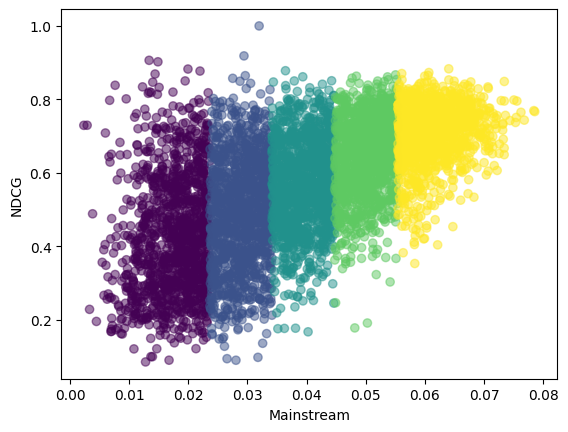

In [20]:
### Convert results to dataframe
### Save the dataframes
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrmain"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrmain"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrmain"]["Ave_mtc"][group]
    for t in results["usrmain"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user main.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Mainstream")
plt.show()

In [90]:
df[np.isnan(df)] = 0
pearsonr(df["metric"], df["NDCG"])

(0.624745272753505, 0.0)

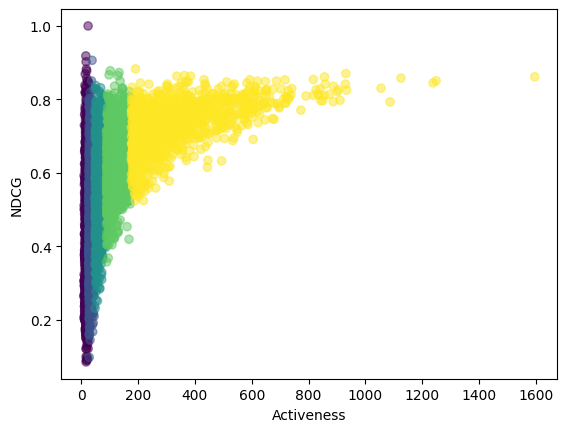

In [91]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["activeness"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["activeness"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["activeness"]["Ave_mtc"][group]
    for t in results["activeness"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user act.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Activeness")
plt.show()

In [93]:
df[np.isnan(df)] = 0
pearsonr(df["metric"], df["NDCG"])

(0.5678238988296898, 0.0)

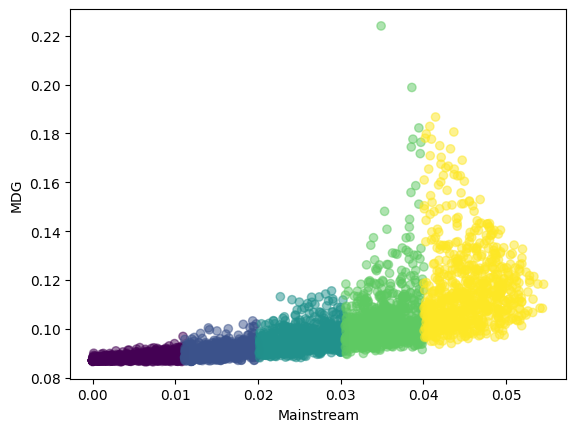

In [94]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmmain"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmmain"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmmain"]["Ave_mtc"][group]
    for t in results["itmmain"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item main.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Mainstream")
plt.show()

In [95]:
pearsonr(df["metric"], df["Performance"])

(0.7000574241693652, 0.0)

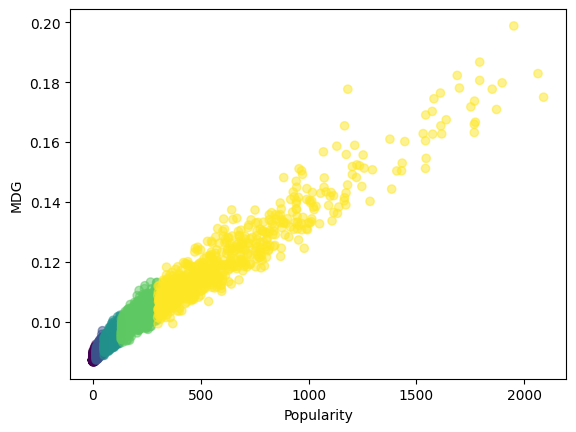

In [96]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["popularity"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["popularity"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["popularity"]["Ave_mtc"][group]
    for t in results["popularity"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item pop.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Popularity")
plt.show()

In [97]:
pearsonr(df["metric"], df["Performance"])

(0.9769867092210796, 0.0)

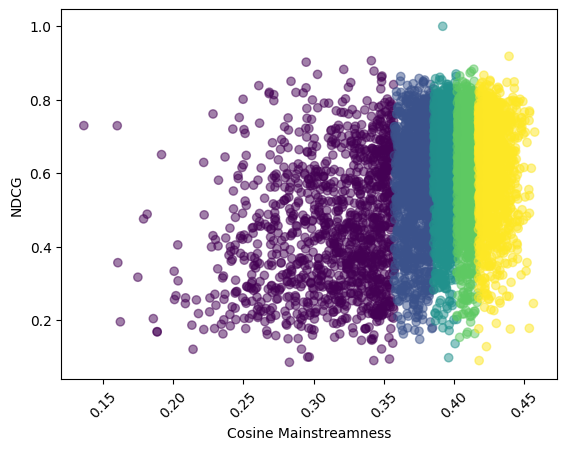

In [44]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrcos"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrcos"]["Ave_mtc"][group]
    for t in results["usrcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user cosine.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [45]:
df[np.isnan(df)] = 0
pearsonr(df["metric"], df["NDCG"])

(0.3759304556738151, 4.6463253668348325e-202)

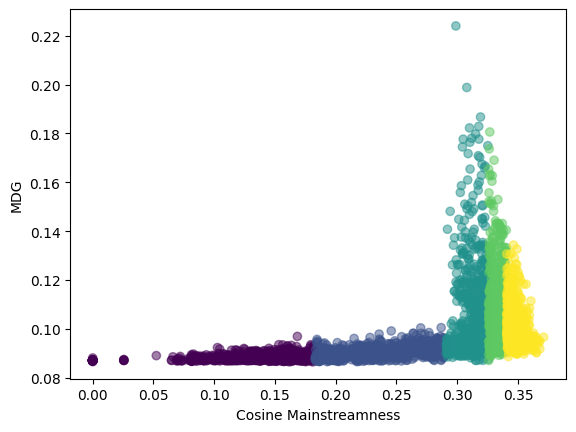

In [46]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmcos"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmcos"]["Ave_mtc"][group]
    for t in results["itmcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item cos.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Cosine Mainstreamness")
plt.show()

In [48]:
pearsonr(df["metric"], df["Performance"])

(0.47871314901187567, 1.3960809573468873e-211)

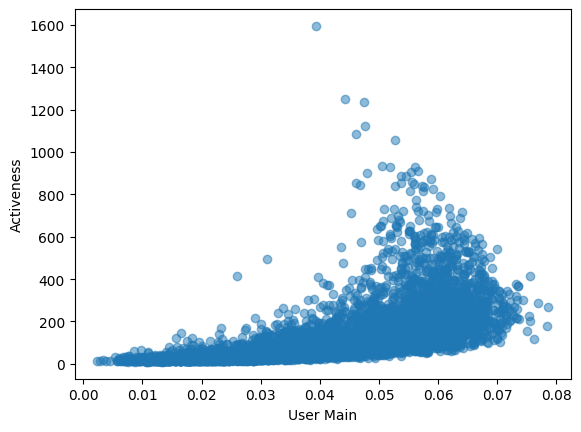

In [109]:
df = {"Activeness": activeness, "User Main": user_mainstreamness}
df = pd.DataFrame(df)
plt.scatter(df["User Main"], df["Activeness"], alpha=0.5)
plt.ylabel("Activeness")
plt.xlabel("User Main")
plt.show()

In [110]:
pearsonr(df["User Main"], df["Activeness"])

(0.6237111997916119, 0.0)

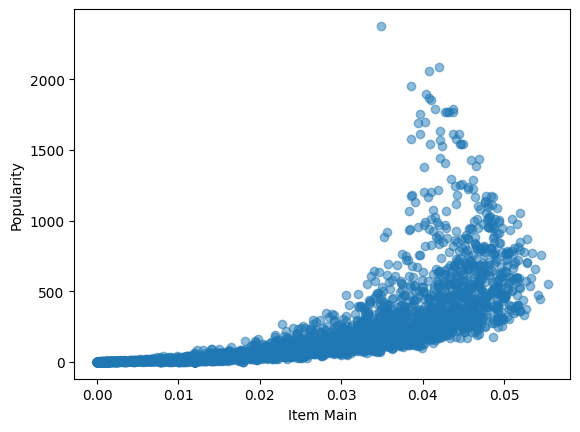

In [111]:
df = {"Popularity": popularity, "Item Main": item_mainstreamness}
df = pd.DataFrame(df)
plt.scatter(df["Item Main"],df["Popularity"], alpha=0.5)
plt.ylabel("Popularity")
plt.xlabel("Item Main")
plt.show()

In [112]:
pearsonr(df["Item Main"],df["Popularity"])

(0.6931139645673442, 0.0)

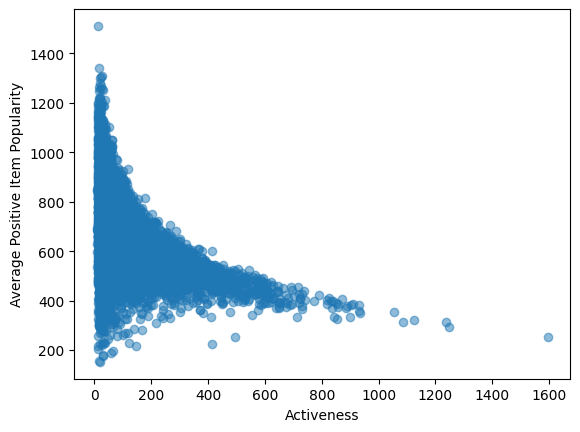

In [113]:
act_pop = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += popularity[tt]
    sum /= len(idx)
    act_pop.append(sum)

df = {"Activeness": activeness, "Ave_pop": act_pop}
df = pd.DataFrame(df)
plt.scatter(df["Activeness"], df["Ave_pop"], alpha=0.5)
plt.ylabel("Average Positive Item Popularity")
plt.xlabel("Activeness")
plt.show()

In [114]:
pearsonr(df["Activeness"], df["Ave_pop"])

(-0.46947657414943755, 0.0)

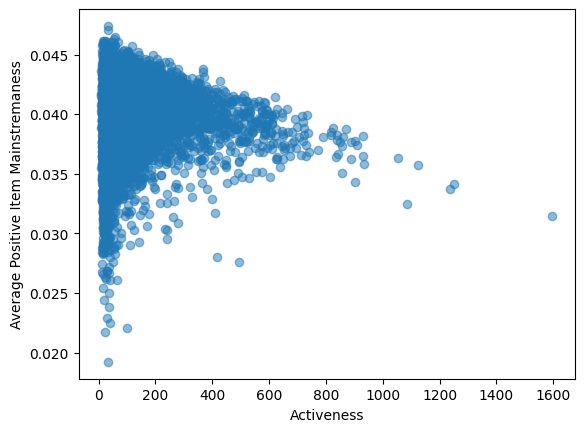

In [115]:
act_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += item_mainstreamness[tt]
    sum /= len(idx)
    act_main.append(sum)

df = {"Activeness": activeness, "Ave_main": act_main}
df = pd.DataFrame(df)
plt.scatter(df["Activeness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Mainstremaness")
plt.xlabel("Activeness")
plt.show()

In [116]:
pearsonr(df["Activeness"], df["Ave_main"])

(0.014263402334110676, 0.26771413737450955)

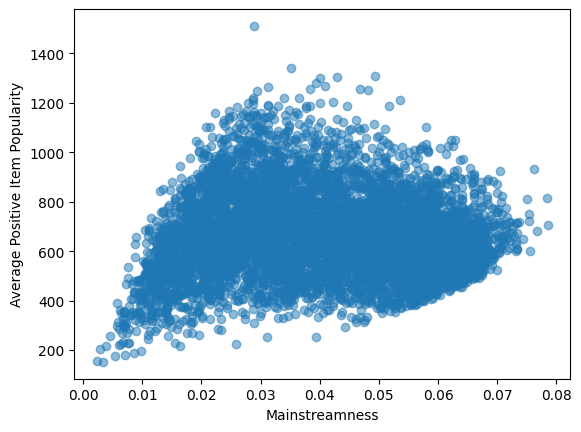

In [117]:
main_pop = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += popularity[tt]
    sum /= len(idx)
    main_pop.append(sum)

df = {"Mainstreamness": user_mainstreamness, "Ave_pop": main_pop}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_pop"], alpha=0.5)
plt.ylabel("Average Positive Item Popularity")
plt.xlabel("Mainstreamness")
plt.show()

In [118]:
pearsonr(df["Mainstreamness"], df["Ave_pop"])

(0.013309457005258603, 0.3010386545476253)

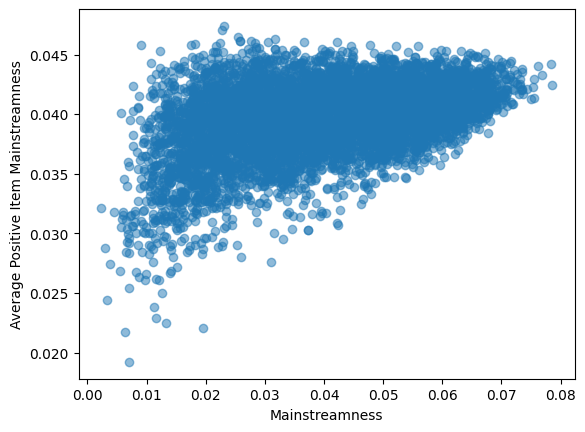

In [119]:
main_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += item_mainstreamness[tt]
    sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": user_mainstreamness, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Mainstreamness")
plt.xlabel("Mainstreamness")
plt.show()

In [120]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.4309782987977978, 9.264311295779618e-272)

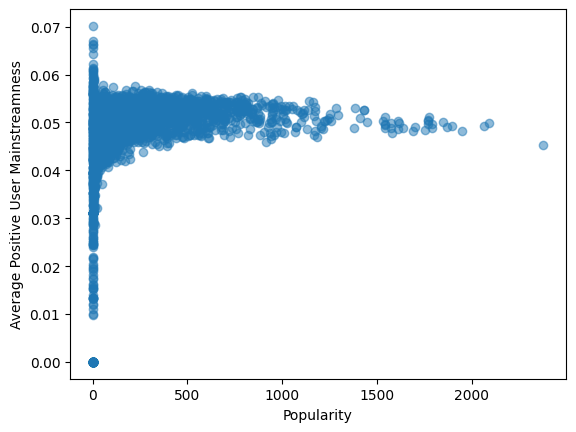

In [121]:
pop_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += user_mainstreamness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    pop_main.append(sum)

df = {"Popularity": popularity, "Ave_main": pop_main}
df = pd.DataFrame(df)
plt.scatter(df["Popularity"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Mainstreamness")
plt.xlabel("Popularity")
plt.show()

In [122]:
pearsonr(df["Popularity"], df["Ave_main"])

(0.2427873001904271, 7.326809860355618e-51)

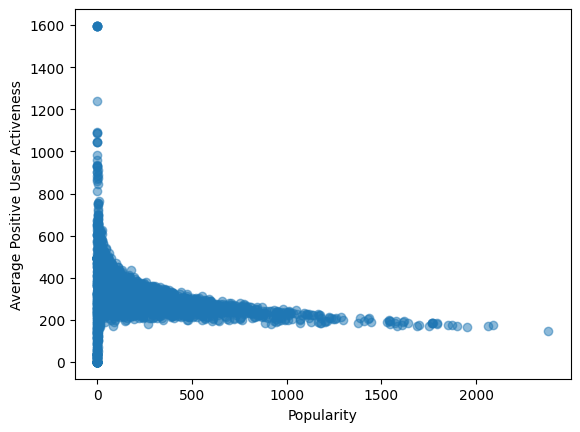

In [123]:
pop_act = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += activeness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    pop_act.append(sum)

df = {"Popularity": popularity, "Ave_act": pop_act}
df = pd.DataFrame(df)
plt.scatter(df["Popularity"], df["Ave_act"], alpha=0.5)
plt.ylabel("Average Positive User Activeness")
plt.xlabel("Popularity")
plt.show()

In [124]:
pearsonr(df["Popularity"], df["Ave_act"])

(-0.3379804914467983, 1.0604078299576217e-99)

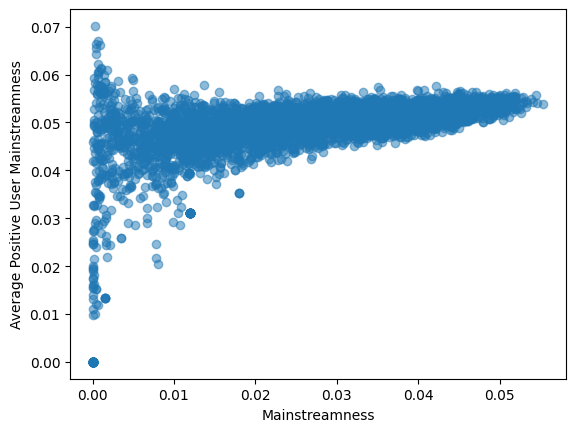

In [126]:
main_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += user_mainstreamness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": item_mainstreamness, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Mainstreamness")
plt.xlabel("Mainstreamness")
plt.show()

In [127]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.5014591394927722, 2.8962247618599352e-235)

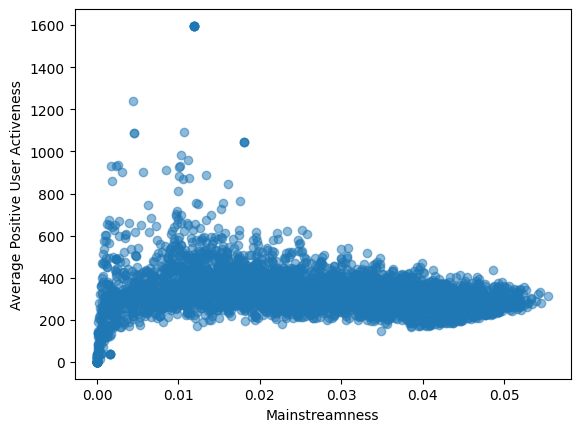

In [128]:
main_act = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += activeness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_act.append(sum)

df = {"Mainstreamness": item_mainstreamness, "Ave_act": main_act}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_act"], alpha=0.5)
plt.ylabel("Average Positive User Activeness")
plt.xlabel("Mainstreamness")
plt.show()

In [129]:
pearsonr(df["Mainstreamness"], df["Ave_act"])

(-0.1449907655544765, 7.280231719814169e-19)

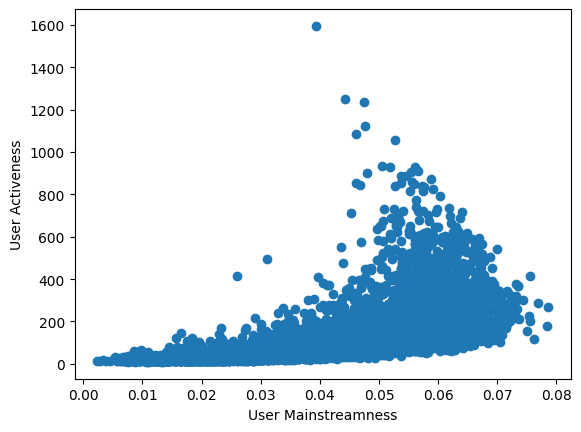

In [130]:
df = {"User Mainstreamness": user_mainstreamness, "User Activeness": activeness}
df = pd.DataFrame(df)
plt.scatter(df["User Mainstreamness"], df["User Activeness"])
plt.ylabel("User Activeness")
plt.xlabel("User Mainstreamness")
plt.show()

In [131]:
pearsonr(df["User Mainstreamness"], df["User Activeness"])

(0.6237111997916119, 0.0)

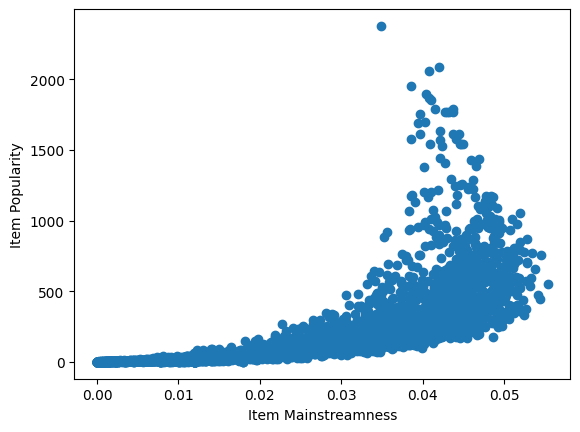

In [132]:
df = {"Item Mainstreamness": item_mainstreamness, "Item Popularity": popularity}
df = pd.DataFrame(df)
plt.scatter(df["Item Mainstreamness"], df["Item Popularity"])
plt.ylabel("Item Popularity")
plt.xlabel("Item Mainstreamness")
plt.show()

In [133]:
pearsonr(df["Item Mainstreamness"], df["Item Popularity"])

(0.6931139645673442, 0.0)

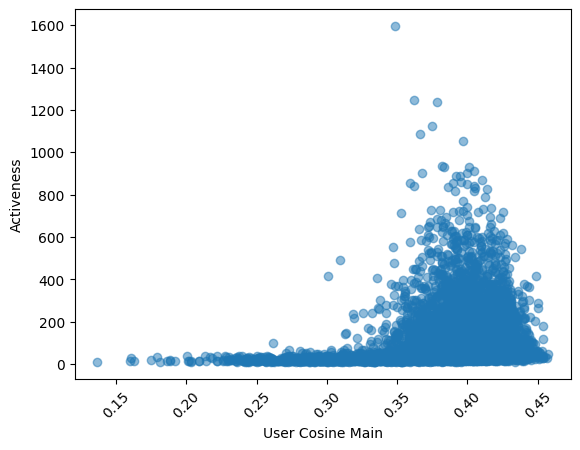

In [65]:
df = {"Activeness": activeness, "User Main": cos_similar}
df = pd.DataFrame(df)
plt.scatter(df["User Main"], df["Activeness"], alpha=0.5)
plt.ylabel("Activeness")
plt.xlabel("User Cosine Main")
plt.xticks(rotation=45)
plt.show()

In [66]:
pearsonr(df["User Main"], df["Activeness"])

(0.23648289553385937, 1.5214311729578575e-77)

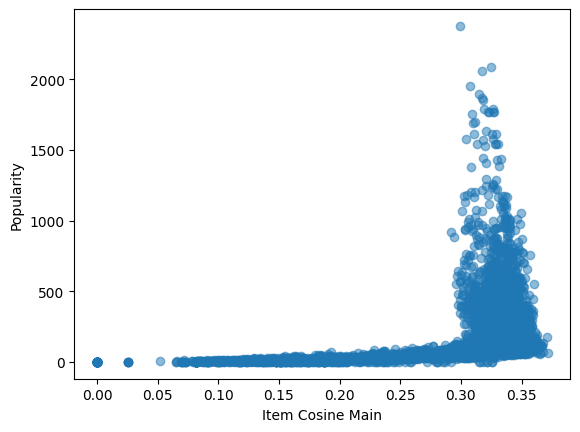

In [67]:
df = {"Popularity": popularity, "Item Main": cos_similar_item}
df = pd.DataFrame(df)
plt.scatter(df["Item Main"],df["Popularity"], alpha=0.5)
plt.ylabel("Popularity")
plt.xlabel("Item Cosine Main")
plt.show()

In [68]:
pearsonr(df["Item Main"],df["Popularity"])

(0.4411844799776532, 2.3031062305994983e-176)

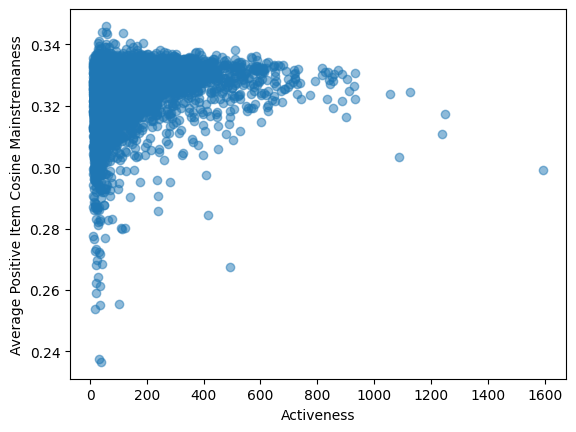

In [69]:
act_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar_item[tt]
    sum /= len(idx)
    act_main.append(sum)

df = {"Activeness": activeness, "Ave_main": act_main}
df = pd.DataFrame(df)
plt.scatter(df["Activeness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Cosine Mainstremaness")
plt.xlabel("Activeness")
plt.show()

In [70]:
pearsonr(df["Activeness"], df["Ave_main"])

(0.2731420143274789, 8.196928741701036e-104)

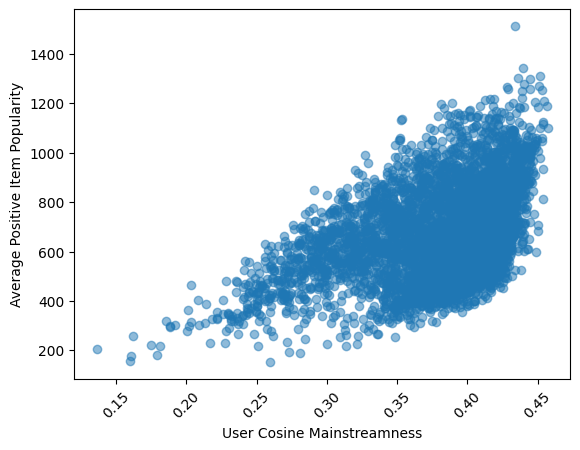

In [71]:
main_pop = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += popularity[tt]
    sum /= len(idx)
    main_pop.append(sum)

df = {"Mainstreamness": cos_similar, "Ave_pop": main_pop}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_pop"], alpha=0.5)
plt.ylabel("Average Positive Item Popularity")
plt.xlabel("User Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [72]:
pearsonr(df["Mainstreamness"], df["Ave_pop"])

(0.45831948205814255, 1.5561104156217e-311)

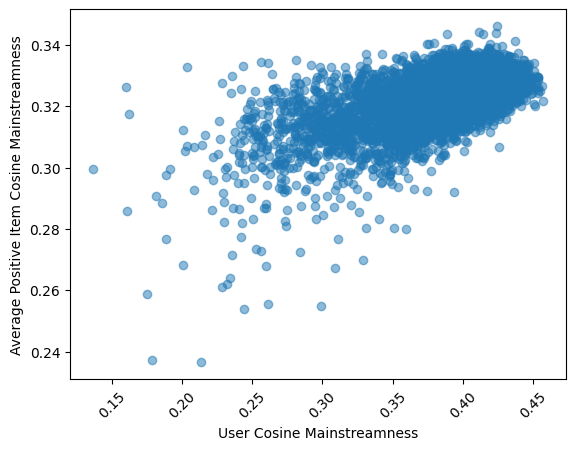

In [73]:
main_main = []
for t in range(Rec_train.shape[0]):
    idx = [i for i,x in enumerate(Rec_train[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar_item[tt]
    sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": cos_similar, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive Item Cosine Mainstreamness")
plt.xlabel("User Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

In [74]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.6237050951593605, 0.0)

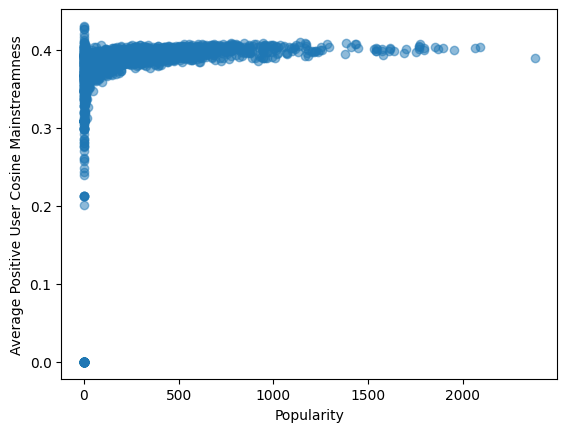

In [75]:
pop_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar[tt]
    if len(idx) != 0:
        sum /= len(idx)
    pop_main.append(sum)

df = {"Popularity": popularity, "Ave_main": pop_main}
df = pd.DataFrame(df)
plt.scatter(df["Popularity"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Cosine Mainstreamness")
plt.xlabel("Popularity")
plt.show()

In [76]:
pearsonr(df["Popularity"], df["Ave_main"])

(0.23979160509711617, 1.273227523762822e-49)

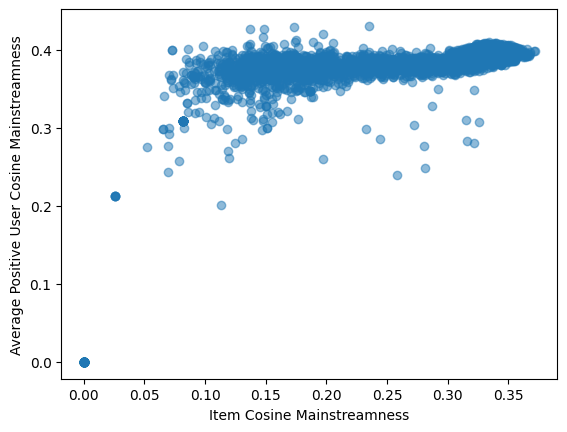

In [77]:
main_main = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += cos_similar[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_main.append(sum)

df = {"Mainstreamness": cos_similar_item, "Ave_main": main_main}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_main"], alpha=0.5)
plt.ylabel("Average Positive User Cosine Mainstreamness")
plt.xlabel("Item Cosine Mainstreamness")
plt.show()

In [78]:
pearsonr(df["Mainstreamness"], df["Ave_main"])

(0.5676999143019926, 2.914612927e-315)

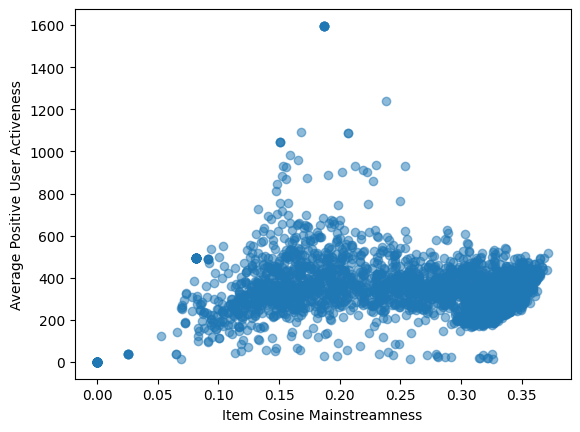

In [79]:
main_act = []
for t in range(Rec_train_item.shape[0]):
    idx = [i for i,x in enumerate(Rec_train_item[t]) if x == 1 ]
    sum = 0
    for tt in idx:
        sum += activeness[tt]
    if len(idx) != 0:
        sum /= len(idx)
    main_act.append(sum)

df = {"Mainstreamness": cos_similar_item, "Ave_act": main_act}
df = pd.DataFrame(df)
plt.scatter(df["Mainstreamness"], df["Ave_act"], alpha=0.5)
plt.ylabel("Average Positive User Activeness")
plt.xlabel("Item Cosine Mainstreamness")
plt.show()

In [80]:
pearsonr(df["Mainstreamness"], df["Ave_act"])

(-0.03622076124576501, 0.027454921165790437)

In [ ]:
### Original embedding from Rec

In [19]:
cosine = Rec.dot(Rec.T)
l2 = np.sqrt(np.sum(Rec * Rec, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine = cosine / l2.dot(l2.T)

Rec_item = Rec.T
cosine_item = Rec_item.dot(Rec_item.T)
l2 = np.sqrt(np.sum(Rec_item * Rec_item, axis = 1))
l2 = l2.reshape([l2.shape[0],1])
cosine_item /= l2.dot(l2.T)
cosine_item[np.isnan(cosine_item)] = 0

In [20]:
for i in range(cosine.shape[0]):
    cosine[i][i] = 0
cos_similar = []
for t in range(cosine.shape[0]):
    cos_similar.append(sum(cosine[t])/cosine.shape[0])
cos_similar = np.array(cos_similar)

for i in range(cosine_item.shape[0]):
    cosine_item[i][i] = 0
cos_similar_item = []
for t in range(cosine_item.shape[0]):
    cos_similar_item.append(sum(cosine_item[t])/cosine_item.shape[0])
cos_similar_item = np.array(cos_similar_item)

In [21]:
cos_sort = (np.sort(cos_similar), np.argsort(cos_similar))
cos_sort_item = (np.sort(cos_similar_item), np.argsort(cos_similar_item))

In [22]:
### K is the number of groups
idx_ = []
k = 5
results = {"usrmain":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "activeness":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "usrcos":{"NDCG":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]},
           "itmmain":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "popularity":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}, "itmcos":{"Performance":[], "Ave_rank":[], "Ave_mtc":[], "Metric":[]}}
num_user = Rec.shape[0]
bt_user = int(num_user/k)
num_item = Rec.shape[1]
bt_item = int(num_item/k)
for i in range(k):
    results["usrmain"]["NDCG"].append(NDCG[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_rank"].append(Ave_rank_user[usrmain_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrmain"]["Ave_mtc"].append(np.mean(usrmain_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrmain"]["Metric"].append(usrmain_sort[0][i*bt_user:(i+1)*bt_user])
    results["activeness"]["NDCG"].append(NDCG[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_rank"].append(Ave_rank_user[act_sort[1][i*bt_user:(i+1)*bt_user]])
    results["activeness"]["Ave_mtc"].append(np.mean(act_sort[0][i*bt_user:(i+1)*bt_user]))
    results["activeness"]["Metric"].append(act_sort[0][i*bt_user:(i+1)*bt_user])
    results["usrcos"]["NDCG"].append(NDCG[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_rank"].append(Ave_rank_user[cos_sort[1][i*bt_user:(i+1)*bt_user]])
    results["usrcos"]["Ave_mtc"].append(np.mean(cos_sort[0][i*bt_user:(i+1)*bt_user]))
    results["usrcos"]["Metric"].append(cos_sort[0][i*bt_user:(i+1)*bt_user])
    
    results["itmmain"]["Performance"].append(Performance[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_rank"].append(Ave_rank_item[itmmain_sort[1][i*bt_item:(i+1)*bt_item]])
    results["itmmain"]["Ave_mtc"].append(np.mean(itmmain_sort[0][i*bt_item:(i+1)*bt_item]))
    results["itmmain"]["Metric"].append(itmmain_sort[0][i*bt_item:(i+1)*bt_item])
    results["popularity"]["Performance"].append(Performance[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_rank"].append(Ave_rank_item[pop_sort[1][i*bt_item:(i+1)*bt_item]])
    results["popularity"]["Ave_mtc"].append(np.mean(pop_sort[0][i*bt_item:(i+1)*bt_item]))
    results["popularity"]["Metric"].append(pop_sort[0][i*bt_item:(i+1)*bt_item])
    results["itmcos"]["Performance"].append(Performance[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_rank"].append(Ave_rank_item[cos_sort_item[1][i*bt_item:(i+1)*bt_item]])
    results["itmcos"]["Ave_mtc"].append(np.mean(cos_sort_item[0][i*bt_item:(i+1)*bt_item]))
    results["itmcos"]["Metric"].append(cos_sort_item[0][i*bt_item:(i+1)*bt_item])

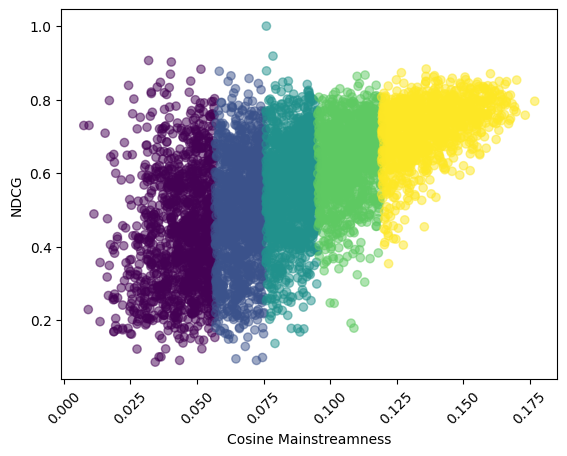

In [23]:
df = {"NDCG": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["usrcos"]["NDCG"][group]:
        df["NDCG"].append(t)
    for t in results["usrcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["usrcos"]["Ave_mtc"][group]
    for t in results["usrcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/user cosine.csv")
plt.scatter(df["metric"], df["NDCG"], c=df["group"], alpha=0.5)
plt.ylabel("NDCG")
plt.xlabel("Cosine Mainstreamness")
plt.xticks(rotation=45)
plt.show()

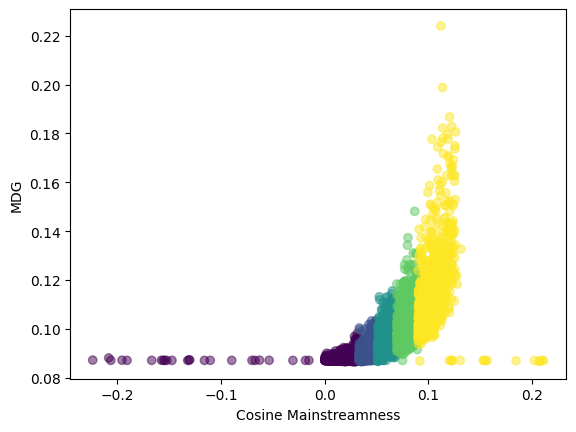

In [24]:
df = {"Performance": [], "Ave_rank":[], "metric": [], "group": [], "ave_metric": []}
for group in range(k):
    for t in results["itmcos"]["Performance"][group]:
        df["Performance"].append(t)
    for t in results["itmcos"]["Ave_rank"][group]:
        df["Ave_rank"].append(t)
    ave_metric_ = results["itmcos"]["Ave_mtc"][group]
    for t in results["itmcos"]["Metric"][group]:
        df["metric"].append(t)
        df["group"].append(group)
        df["ave_metric"].append(ave_metric_)
df = pd.DataFrame(df)
df.to_csv("./data/item cos.csv")
plt.scatter(df["metric"], df["Performance"], c=df["group"], alpha=0.5)
plt.ylabel("MDG")
plt.xlabel("Cosine Mainstreamness")
plt.show()